In [50]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy import sparse
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
import torch
import torch.nn as nn
from torchmetrics.classification import BinaryF1Score
from tqdm import tqdm

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Read data

In [3]:
train_data = pd.read_csv("./data/train.csv", header=None)
train_data

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [5]:
train_data.shape

(120000, 3)

In [8]:
# reduce to 1,000 rows
train_data = train_data[0:1000]

In [31]:
test_data = pd.read_csv("./data/test.csv", header=None)

In [32]:
test_data.shape

(7600, 3)

In [33]:
# reduce to 1,000 rows
test_data = test_data[0:1000]

#### Rename columns

In [9]:
train_data.rename(columns={0: 'label', 1: 'title', 2: 'description'}, inplace=True)

/var/folders/gg/c_1qbqks74vfktzlk54zz3240000gn/T/ipykernel_11429/1493289334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.rename(columns={0: 'label', 1: 'title', 2: 'description'}, inplace=True)


In [34]:
test_data.rename(columns={0: 'label', 1: 'title', 2: 'description'}, inplace=True)

In [35]:
test_data

,label,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
995,2,Mariners riding the Ichiro wave,Ichiro Suzuki singled three times last night t...
996,2,Wharf marks debut with wickets,In-form Alex Wharf made an impressive start to...
997,2,Roddick blisters junior champ,By the time his match with Andy Roddick was ov...
998,4,"AMD dual-core demo pips Intel, IBM",AMD has demonstrated the company #39;s first d...


#### Merge title and description to create the text column

In [10]:
train_data['text'] = train_data['title'] + train_data['description']

/var/folders/gg/c_1qbqks74vfktzlk54zz3240000gn/T/ipykernel_11429/3258434818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['text'] = train_data['title'] + train_data['description']


In [11]:
train_data

,label,title,description,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
...,...,...,...,...
995,3,U.S. Stocks Rebound as Oil Prices Ease,NEW YORK (Reuters) - U.S. stocks rebounded on...,U.S. Stocks Rebound as Oil Prices Ease NEW YOR...
996,3,Dollar Rises Vs Euro After Asset Data,NEW YORK (Reuters) - The dollar gained agains...,Dollar Rises Vs Euro After Asset Data NEW YORK...
997,4,Bikes Bring Internet to Indian Villagers (AP),"AP - For 12-year-old Anju Sharma, hope for a b...",Bikes Bring Internet to Indian Villagers (AP)A...
998,4,Celebrity Chefs Are Everywhere in Vegas,By ADAM GOLDMAN LAS VEGAS (AP) -- The waite...,Celebrity Chefs Are Everywhere in VegasBy ADAM...


In [36]:
test_data['text'] = test_data['title'] + test_data['description']

In [37]:
test_data

,label,title,description,text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,Fears for T N pension after talksUnions repres...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,Ky. Company Wins Grant to Study Peptides (AP)A...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,Prediction Unit Helps Forecast Wildfires (AP)A...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,Calif. Aims to Limit Farm-Related Smog (AP)AP ...
...,...,...,...,...
995,2,Mariners riding the Ichiro wave,Ichiro Suzuki singled three times last night t...,Mariners riding the Ichiro waveIchiro Suzuki s...
996,2,Wharf marks debut with wickets,In-form Alex Wharf made an impressive start to...,Wharf marks debut with wicketsIn-form Alex Wha...
997,2,Roddick blisters junior champ,By the time his match with Andy Roddick was ov...,Roddick blisters junior champBy the time his m...
998,4,"AMD dual-core demo pips Intel, IBM",AMD has demonstrated the company #39;s first d...,"AMD dual-core demo pips Intel, IBMAMD has demo..."


# Explore tokenization

In [12]:
def tokenize(text):
    # default delimiter is space
    return text.split()

In [13]:
tokenized_docs = []
documents = train_data['text'].values
for doc in documents:
    tokenized_docs.append(tokenize(doc))
tokenized_docs[2]

['Oil',
 'and',
 'Economy',
 'Cloud',
 "Stocks'",
 'Outlook',
 '(Reuters)Reuters',
 '-',
 'Soaring',
 'crude',
 'prices',
 'plus',
 'worries\\about',
 'the',
 'economy',
 'and',
 'the',
 'outlook',
 'for',
 'earnings',
 'are',
 'expected',
 'to\\hang',
 'over',
 'the',
 'stock',
 'market',
 'next',
 'week',
 'during',
 'the',
 'depth',
 'of',
 'the\\summer',
 'doldrums.']

In [14]:
def better_tokenize(text):
    # make all text lowercase to get rid of case issues, not sure how this will affect the model performance but I'll give it a try nonetheless
    text = text.lower()
    text = text.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace(";", " ; ").replace("!", " ! ").replace("?", " ? ").replace("’ve", "  ’ve").replace("’re", " ’re")
    all_tokens = text.split()
    for i in range(len(all_tokens)):
        all_tokens[i] = all_tokens[i].strip()
    return all_tokens

In [15]:
tokenized_docs = []
documents = train_data['text'].values
for doc in documents:
    tokenized_docs.append(better_tokenize(doc))
tokenized_docs[2]

['oil',
 'and',
 'economy',
 'cloud',
 "stocks'",
 'outlook',
 '(reuters)reuters',
 '-',
 'soaring',
 'crude',
 'prices',
 'plus',
 'worries\\about',
 'the',
 'economy',
 'and',
 'the',
 'outlook',
 'for',
 'earnings',
 'are',
 'expected',
 'to\\hang',
 'over',
 'the',
 'stock',
 'market',
 'next',
 'week',
 'during',
 'the',
 'depth',
 'of',
 'the\\summer',
 'doldrums',
 '.']

#### This is a better tokenizer than what we had earlier and addresses the issues with the older tokenizer() method.

#### Creating the Term-Document Matrix

In [17]:
def build_sparse_tdm(all_docs):
    master_list = []
    min_word_freq = 2
    all_word_counts = defaultdict(int)
    for doc in all_docs:
        # iterate over all words in document
        for word in doc:
            all_word_counts[word] += 1
    # don't consider words with count less that min_word_freq
    for word in all_word_counts.keys():
        if not all_word_counts[word] < min_word_freq:
            master_list.append(word)
    tdm_mat = np.zeros((len(all_docs), len(master_list)))
    # print(f"master list {master_list}")
    # again iterate over all words but this time create the matrix with column 
    # number indiicating the index of the word in the master_list and row indicating
    # each document. Maintain a count of each word in each document.
    for row in range(len(all_docs)):
        for word in all_docs[row]:
            # print(f"Considering word {word}")
            if word in master_list:
                col = master_list.index(word)
                tdm_mat[row][col] += 1
    tdm_mat_sparse = sparse.csr_matrix(tdm_mat)
    return tdm_mat_sparse, master_list

In [18]:
# test the method
test_tokens = [['this', 'is', 'a', 'cat'], ['this', 'cat', 'is', 'brown']]
print(build_sparse_tdm(test_tokens))

(<2x3 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>, ['this', 'is', 'cat'])


In [19]:
# create the sparse TDM for our tokenized training data 
sparse_tdm, master_list = build_sparse_tdm(tokenized_docs)
type(sparse_tdm)

scipy.sparse._csr.csr_matrix

# Trying out Logistic Regression

#### Implementing the sigmoid function
$$S(X) = \frac{1}{1+exp(-X)}$$

In [20]:
def sigmoid(X):
    # print(f"Calculating sigmoid for\n {X}")
    result = 1 / (1 + np.exp(-X))
    return result

In [21]:
# test the method
sigmoid(np.array([1, 2, 3]))

array([0.73105858, 0.88079708, 0.95257413])

#### Implementing log likelihood
$$ll(\beta) = \sum_{i}^{n}y_ilog(p(x_i)) + (1-y_i)log(1-p(x_i))$$

Here,
$$p(x_i) = sigmoid(\beta^T.x_i)$$

In [22]:
def log_likelihood(y, X, beta):
    log_likelihood_sum = 0
    for i in range(X.shape[0]):
        x_i = X[i].toarray().reshape(-1, 1)
        beta_transpose = np.transpose(beta)
        # print(f"shape of X[i]: {x_i.shape} and shape of beta: {beta_transpose.shape}")
        dot_prod = np.dot(beta_transpose, x_i)
        p_x_i = sigmoid(dot_prod)
        # print(f"p_x_i: {p_x_i}")
        term_1 = (y[i] * np.log(p_x_i))
        term_2 = (1 - y[i]) * np.log(1 - p_x_i)
        full_term = term_1 + term_2
        log_likelihood_sum += full_term
    return log_likelihood_sum

#### Update Beta value by computing gradient

$$\beta_{new} = \beta_{old} - \alpha\frac{\delta}{\delta \beta}ll(\beta)$$

where,

$$\frac{\delta}{\delta \beta}ll(\beta) = (sigmoid(\beta x_i - y_i))x_i$$

In [23]:
def compute_gradient(x_i, y_i, beta, alpha):
    #print("Compute gradient")
    # print(f"x_i: {x_i.shape}, y_i: {y_i}, beta: {beta.shape}, alpha: {alpha}")
    t_1 = sigmoid(np.dot(np.transpose(beta), x_i)) - y_i
    #print("t_1", t_1)
    t_2 = t_1 * x_i
    return (np.subtract(beta, (alpha * t_2)))

#### Adding intercept column

Adding a last column of all 1s to the sparse matrix

In [24]:
def add_intercept_col(X):
    return sparse.hstack((X, np.ones((X.shape[0]))[:,None])).tocsr()

#### Combining all the above methods within the `logistic_regression()` method

In [25]:
def logistic_regression(X, y, learning_rate, num_step):
    epoch = EPOCH_VAL
    max_rows = X.shape[0]
    log_val = []
    # add intercept column
    X = add_intercept_col(X)
    beta = np.zeros(X.shape[1]).reshape(-1, 1)
    # print(beta)
    for ep in range(epoch):
        print(f"Epoch: {ep}")
        for step in range(num_step):
            # print("Step: ", i)
            # pick a random i
            i = np.random.randint(max_rows)
            x_i = X[i].toarray().reshape(-1, 1)
            beta = compute_gradient(x_i, y[i], beta, learning_rate)
            # print(f"Beta after computing gradient is: \n {beta}")
            # print(beta)
            if step % 50 == 0:
                log_l_val = log_likelihood(y, X, beta)
                # print("Appending to log_val")
                log_val.append(log_l_val)
    return beta, log_val

#### Implementing the `predict()` method

Here we make use of the logistic regression equation:

$$P(y=1|x, \beta) = \frac{1}{1 + exp(-\sum_{i=1}^{N}x_i\beta_i)}$$

In [26]:
def predict(text, beta):
    tokenized = better_tokenize(text)
    # using the text create a vector with same shape as that of a 
    # single row within the sparse matrix
    # initially let the vector be all 0s
    x = np.zeros(sparse_tdm.shape[1])
    # for each word in our tokenized text
    for word in tokenized:
        # fetch index of that word if it exists
        if word in master_list:
            arr_index = master_list.index(word)
            # increment count of that array index
            x[arr_index] += 1
    # now predict using the vector we just created
    all_sum = 0
    x = x.reshape(-1, 1)
    # print(f"x: {x.shape}, beta: {beta.shape}")
    # calculate P using the logistic regression equation
    for i in range(len(x)):
        all_sum += (x[i] * beta[i])
    y_pred = sigmoid(all_sum)
    return y_pred[0]    

#### Training the logistic regression model

In [28]:
X = sparse_tdm
y = train_data['label'].values
l_rate = 0.001
num_step = 3100
EPOCH_VAL = 20
beta, log_l_val = logistic_regression(X, y, l_rate, num_step)
# print(log_l_val)

Epoch: 0


/var/folders/gg/c_1qbqks74vfktzlk54zz3240000gn/T/ipykernel_11429/2635681046.py:11: RuntimeWarning: divide by zero encountered in log
  term_2 = (1 - y[i]) * np.log(1 - p_x_i)
/var/folders/gg/c_1qbqks74vfktzlk54zz3240000gn/T/ipykernel_11429/2635681046.py:11: RuntimeWarning: invalid value encountered in multiply
  term_2 = (1 - y[i]) * np.log(1 - p_x_i)


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19


[Text(0.5, 1.0, 'Log-likelihood every 50 steps')]

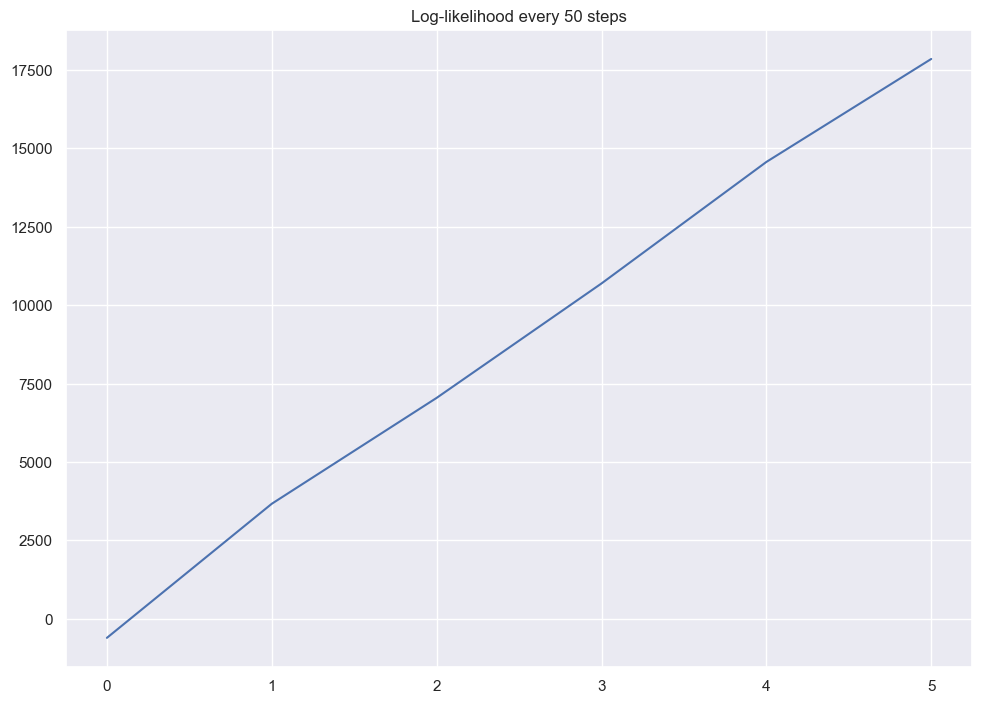

In [29]:
log_vals = []
steps = []
i = 0
for l in log_l_val:
    log_vals.append(l[0][0])
    steps.append(i)
    i += 50
# plt.plot(steps, log_vals)
sns.lineplot(data=log_vals).set(title="Log-likelihood every 50 steps")

In [39]:
# read in the test set
X_test = test_data['text'].values
y_test = test_data['label'].values.tolist()

In [43]:
y_pred = []
for x in X_test:
    y_pred.append(predict(x, beta).round())
print(accuracy_score(y_test, y_pred))

0.268


# Logistic Regression with PyTorch

In [14]:
def to_sparse_tensor_old(sparse_mat_ip):
    print(f"Input shape: {sparse_mat_ip.shape}")
    sparse_coo = sparse_mat_ip.tocoo()
    print(f"Post shape: {sparse_coo.shape}")
    print(f"Row: {len(sparse_coo.row.tolist())}, Col: {len(sparse_coo.col.tolist())}, data: {len(sparse_coo.data)}")
    sparse_tensor = torch.sparse.LongTensor(torch.LongTensor([sparse_coo.row.tolist(), sparse_coo.col.tolist()]),
                              torch.LongTensor(sparse_coo.data))
    print(f"Post post shape: {sparse_tensor.shape}")
    return sparse_tensor

In [44]:
def to_sparse_tensor(sparse_mat_ip):
    print(f"Input shape: {sparse_mat_ip.shape}")
    sparse_coo = sparse_mat_ip.tocoo()
    print(f"Post shape: {sparse_coo.shape}")
    print(f"Row: {len(sparse_coo.row.tolist())}, Col: {len(sparse_coo.col.tolist())}, data: {len(sparse_coo.data)}")
    values = sparse_coo.data
    indices = np.vstack((sparse_coo.row, sparse_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = sparse_coo.shape

    sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()
    print(f"Post post shape: {sparse_tensor.shape}")
    return sparse_tensor

In [52]:
def rebuild_sparse_tdm(all_docs, word_index):
    for doc in tqdm(all_docs):
        # print(doc)
        tdm_mat = np.zeros((len(all_docs), len(word_index)))
        # print(f"master list {master_list}")
        # again iterate over all words but this time create the matrix
        for row in range(len(all_docs)):
            for word in all_docs[row]:
                # print(f"Considering word {word}")
                if word in word_index:
                    col = word_index.index(word)
                    tdm_mat[row][col] += 1
    tdm_mat_sparse = sparse.csr_matrix(tdm_mat)
    return tdm_mat_sparse

In [48]:
sparse_tdm_tensor = to_sparse_tensor(sparse_tdm)
y_train_tensor = torch.tensor(train_data['label'].values)

Input shape: (1000, 3974)
Post shape: (1000, 3974)
Row: 31300, Col: 31300, data: 31300
Post post shape: torch.Size([1000, 3974])


In [53]:
# tokenize_test
X_test_tokenized = []
for word in tqdm(X_test):
    X_test_tokenized.append(better_tokenize(word))
X_test_tdm = rebuild_sparse_tdm(X_test_tokenized, master_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:13<00:00,  1.48it/s]


In [55]:
X_test_sparse_tensor = to_sparse_tensor(X_test_tdm)
y_test_tensor = torch.tensor(test_data['label'].values)

Input shape: (1000, 3974)
Post shape: (1000, 3974)
Row: 26955, Col: 26955, data: 26955
Post post shape: torch.Size([1000, 3974])


In [56]:
class LogisticRegression(nn.Module):
  
    def __init__(self, input_dim):
        super().__init__()
        output_dim = 1
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        return x

In [57]:
sparse_tdm_tensor[1].float()

tensor([0., 0., 1.,  ..., 0., 0., 0.])

In [58]:
model = LogisticRegression(list(sparse_tdm_tensor[0].shape)[0])

In [ ]:
from numpy.random.mtrand import noncentral_f
def train_py_torch_model(X_train_sparse_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs, pytorch_steps, pytorch_lr, need_to_eval, evaluate_on_n_step, set_wt_decay=False, wt_decay=None, set_optim=False, optim_val=None):
    loss_func = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=pytorch_lr)
    if set_wt_decay:
    print("Setting weight_decay to optimizer")
    optimizer = torch.optim.SGD(model.parameters(), lr=pytorch_lr, weight_decay=wt_decay)
    if set_optim:
    if optim_val == "RMSProp":
        print("Setting optim to RMSProp")
        optimizer = torch.optim.RMSprop(model.parameters(), lr=pytorch_lr)
    elif optim_val == "AdamW":
        print("Setting optim to AdamW")
      optimizer = torch.optim.AdamW(model.parameters(), lr=pytorch_lr)
    else:
      optimizer = None
    loss_every_step = []
    all_dev_loss = []
    all_f1_scores = []
    for epoch_num in range(pytorch_epochs):
    # print(f"Epoch: {epoch_num}")
    # start executing steps
    running_loss = 0.0
    for step_num in range(pytorch_steps):
      # parameter gradients set to 0
      optimizer.zero_grad()
      # pick random data point
      rand_index = np.random.randint(list(X_train_sparse_tensor.shape)[0])
      rand_data_point = X_train_sparse_tensor[rand_index]
      # print(rand_index)
      # pass data to our network
      output = model(rand_data_point.float())
      loss = loss_func(output.squeeze(-1), y[rand_index].float())
      loss.backward()
      optimizer.step()
      # print(f"Loss: {loss.item()}")
      loss_every_step.append(loss.item())
      if need_to_eval:
        if step_num % evaluate_on_n_step == 0:
          # evaluate on validation set
          # switch to evaluation step
          model.eval()
          with torch.no_grad():
            # fetch outputs
            all_outputs = model(X_dev_sparse_tensor.float())
            dev_loss = loss_func(all_outputs.squeeze(-1), y_dev_tensor.float())
            metric = BinaryF1Score()
            # print(all_outputs.squeeze(-1))
            # print(y_dev_tensor.float())
            f1_score = metric(all_outputs.squeeze(-1), y_dev_tensor.float())
            all_f1_scores.append(f1_score.item())
            all_dev_loss.append(dev_loss.item())
          # switch back to training mode
          model.train()
      # log every 50 steps
      # running_loss += loss.item()
      # if step_num % 50 == 0:
      #   print(f"Loss: {running_loss/50}")
      #   running_loss = 0.0
    print("Done")
    return loss_every_step, all_dev_loss, all_f1_scores

In [64]:
from numpy.random.mtrand import noncentral_f
def train_py_torch_model(X_train_sparse_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs, pytorch_steps, pytorch_lr, need_to_eval, evaluate_on_n_step, set_wt_decay=False, wt_decay=None, set_optim=False, optim_val=None):
    loss_func = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=pytorch_lr)
    if set_wt_decay:
        print("Setting weight_decay to optimizer")
        optimizer = torch.optim.SGD(model.parameters(), lr=pytorch_lr, weight_decay=wt_decay)
        if set_optim:
            if optim_val == "RMSProp":
                print("Setting optim to RMSProp")
                optimizer = torch.optim.RMSprop(model.parameters(), lr=pytorch_lr)
            elif optim_val == "AdamW":
                print("Setting optim to AdamW")
                optimizer = torch.optim.AdamW(model.parameters(), lr=pytorch_lr)
            else:
                optimizer = None
    loss_every_step = []
    all_dev_loss = []
    all_f1_scores = []
    for epoch_num in range(pytorch_epochs):
        # print(f"Epoch: {epoch_num}")
        # start executing steps
        running_loss = 0.0
        for step_num in range(pytorch_steps):
            # parameter gradients set to 0
            optimizer.zero_grad()
            # pick random data point
            rand_index = np.random.randint(list(X_train_sparse_tensor.shape)[0])
            rand_data_point = X_train_sparse_tensor[rand_index]
            # print(rand_index)
            # pass data to our network
            output = model(rand_data_point.float())
            loss = loss_func(output.squeeze(-1), y[rand_index].float())
            loss.backward()
            optimizer.step()
            # print(f"Loss: {loss.item()}")
            loss_every_step.append(loss.item())
            if need_to_eval:
                if step_num % evaluate_on_n_step == 0:
                    # evaluate on validation set
                    # switch to evaluation step
                    model.eval()
                    with torch.no_grad():
                        # fetch outputs
                        all_outputs = model(X_dev_sparse_tensor.float())
                        dev_loss = loss_func(all_outputs.squeeze(-1), y_dev_tensor.float())
                        metric = BinaryF1Score()
                        # print(all_outputs.squeeze(-1))
                        # print(y_dev_tensor.float())
                        f1_score = metric(all_outputs.squeeze(-1), y_dev_tensor.float())
                        all_f1_scores.append(f1_score.item())
                        all_dev_loss.append(dev_loss.item())
                    # switch back to training mode
                    model.train()
        # log every 50 steps
        # running_loss += loss.item()
        # if step_num % 50 == 0:
        #   print(f"Loss: {running_loss/50}")
        #   running_loss = 0.0
    print("Done")
    return loss_every_step, all_dev_loss, all_f1_scores

In [ ]:
# epoch 500, steps 3000 and learning rate 0.05
loss_vals, all_dev_loss, all_f1 = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_test_sparse_tensor, y_test_tensor, pytorch_epochs=25, pytorch_steps=3100, pytorch_lr=0.08, need_to_eval=True, evaluate_on_n_step=50)

In [ ]:
loss_vals[::50]

[0.2452917844057083,
 0.459329754114151,
 0.24162933230400085,
 0.14026132225990295,
 1.195487380027771,
 1.4742517471313477,
 0.33271950483322144,
 0.350024551153183,
 0.3946042060852051,
 0.3910132050514221,
 2.3404488563537598,
 1.193013310432434,
 0.2209450602531433,
 0.34481409192085266,
 0.4204856753349304,
 0.41923585534095764,
 0.25699272751808167,
 0.3628966510295868,
 0.3065948784351349,
 0.20569239556789398]

In [ ]:
all_dev_loss[::50]

[tensor(0.4961), tensor(0.4705), tensor(0.4665), tensor(0.4653)]

In [ ]:
all_f1[len(all_f1)-1].tolist()

0.24060150980949402

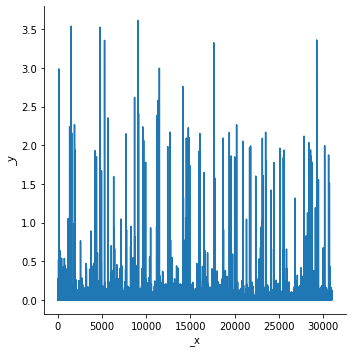

In [ ]:
sns.relplot(data=loss_vals[::50], kind="line")

In [ ]:
# tokenize_dev
X_test_tokenized = []
for word in X_test:
  X_test_tokenized.append(better_tokenize(word))
X_test_tdm = rebuild_sparse_tdm(X_test_tokenized, master_list)

In [ ]:
X_test_sparse_tensor = to_sparse_tensor(X_test_tdm)

Input shape: (1400, 4110)
Post shape: (1400, 4110)
Row: 19246, Col: 19246, data: 19246
Post post shape: torch.Size([1400, 4110])


In [ ]:
model.eval()
with torch.no_grad():
  # fetch outputs
  y_pred = model(X_test_sparse_tensor.float())
model.train()

LogisticRegression(
  (linear): Linear(in_features=4110, out_features=1, bias=True)
)

In [ ]:
y_pred_pytorch = []
for val in y_pred.tolist():
  y_pred_pytorch.append(round(val[0]))

In [ ]:
output_df_pytorch = pd.DataFrame(columns=['index', 'prediction'])
output_df_pytorch['index'] = test_df['index'].values
output_df_pytorch['prediction'] = y_pred_pytorch
output_df_pytorch.to_csv("output_pt.csv", index=False)

## Training and Experiments

Done


[Text(0.5, 1.0, 'Epoch=1, steps=1000')]

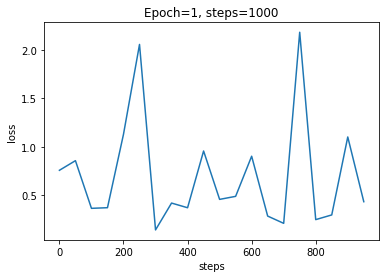

In [ ]:
model = LogisticRegression(list(sparse_tdm_tensor[0].shape)[0])
# Train model for 1000 steps and report loss every 50 steps
loss_vals, all_dev_loss, all_f1 = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=1000, pytorch_lr=0.01, need_to_eval=False, evaluate_on_n_step=50)
data = pd.DataFrame(columns = ['steps', 'loss'])
data['steps'] = list(range(0, 1000, 50))
data['loss'] = loss_vals[::50]

sns.lineplot(data=data, x="steps", y="loss").set(title="Epoch=1, steps=1000")

Done
F1 score on the development data: 0.16393442451953888


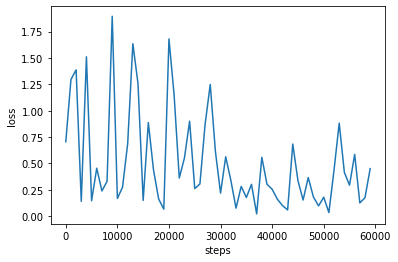

In [ ]:
model = LogisticRegression(list(sparse_tdm_tensor[0].shape)[0])
loss_vals, all_dev_loss, all_f1 = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=30, pytorch_steps=2000, pytorch_lr=0.01, need_to_eval=True, evaluate_on_n_step=2000)
data = pd.DataFrame(columns = ['steps', 'loss'])
data['steps'] = list(range(0, 30*2000, 1000))
data['loss'] = loss_vals[::1000]

sns.lineplot(data=data, x="steps", y="loss")
print(f"F1 score on the development data: {all_f1[-1]}")

In [ ]:
model = LogisticRegression(list(sparse_tdm_tensor[0].shape)[0])

loss_vals_l2_0, all_dev_loss_l2_0, all_f1_l2_0 = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=2000, pytorch_lr=0.01, need_to_eval=True, evaluate_on_n_step=50, set_wt_decay=True, wt_decay=0)

data_l2_0 = pd.DataFrame(columns = ['steps', 'loss', 'F1', 'L2'])
data_l2_0['steps'] = list(range(0, 2000, 50))
data_l2_0['loss'] = all_dev_loss_l2_0
data_l2_0['F1'] = all_f1_l2_0
data_l2_0['L2'] = 0

loss_vals_l2_0_001, all_dev_loss_l2_0_001, all_f1_l2_0_001 = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=2000, pytorch_lr=0.01, need_to_eval=True, evaluate_on_n_step=50, set_wt_decay=True, wt_decay=0.001)
data_l2_0_001 = pd.DataFrame(columns = ['steps', 'loss', 'F1', 'L2'])
data_l2_0_001['steps'] = list(range(0, 2000, 50))
data_l2_0_001['loss'] = all_dev_loss_l2_0_001
data_l2_0_001['F1'] = all_f1_l2_0_001
data_l2_0_001['L2'] = 0.001


loss_vals_l2_0_1, all_dev_loss_l2_0_1, all_f1_l2_0_1 = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=2000, pytorch_lr=0.01, need_to_eval=True, evaluate_on_n_step=50, set_wt_decay=True, wt_decay=0.1)
data_l2_0_1 = pd.DataFrame(columns = ['steps', 'loss', 'F1', 'L2'])
data_l2_0_1['steps'] = list(range(0, 2000, 50))
data_l2_0_1['loss'] = all_dev_loss_l2_0_1
data_l2_0_1['F1'] = all_f1_l2_0_1
data_l2_0_1['L2'] = 0.1

Setting weight_decay to optimizer
Done
Setting weight_decay to optimizer
Done
Setting weight_decay to optimizer
Done


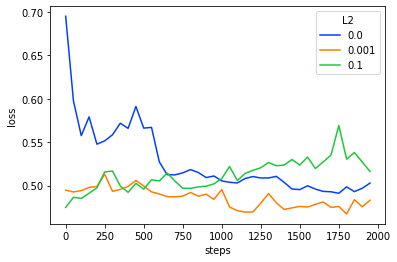

In [ ]:
all_l2_data = pd.concat([data_l2_0, data_l2_0_001, data_l2_0_1], ignore_index=True)
sns.lineplot(data=all_l2_data, y='loss', x='steps', hue='L2', palette='bright')

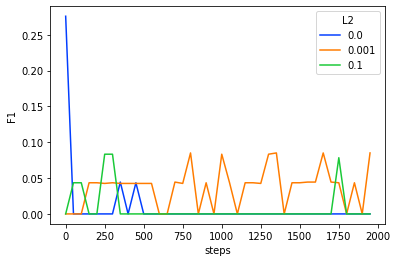

In [ ]:
sns.lineplot(data=all_l2_data, y='F1', x='steps', hue='L2', palette='bright')

In [ ]:

model = LogisticRegression(list(sparse_tdm_tensor[0].shape)[0])

loss_vals_rms, all_dev_loss_rms, all_f1_rms = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=2000, pytorch_lr=0.01, need_to_eval=True, evaluate_on_n_step=50, set_optim=True, optim_val="RMSProp")
data_rms = pd.DataFrame(columns = ['steps', 'loss', 'F1', 'optim'])
data_rms['steps'] = list(range(0, 2000, 50))
data_rms['loss'] = all_dev_loss_rms
data_rms['F1'] = all_f1_rms
data_rms['optim'] = 'RMSProp'

loss_vals_adamw, all_dev_loss_adamw, all_f1_adamw = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=2000, pytorch_lr=0.01, need_to_eval=True, evaluate_on_n_step=50, set_optim=True, optim_val="AdamW")
data_adamw = pd.DataFrame(columns = ['steps', 'loss', 'F1', 'optim'])
data_adamw['steps'] = list(range(0, 2000, 50))
data_adamw['loss'] = all_dev_loss_adamw
data_adamw['F1'] = all_f1_adamw
data_adamw['optim'] = 'AdamW'

Setting optim to RMSProp
Done
Setting optim to AdamW
Done


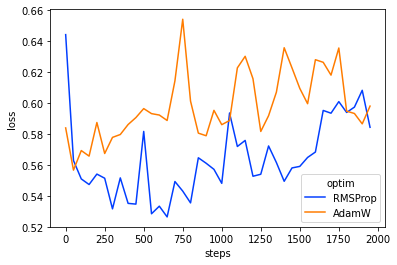

In [ ]:
all_optim_data = pd.concat([data_rms, data_adamw], ignore_index=True)
sns.lineplot(data=all_optim_data, y='loss', x='steps', hue='optim', palette='bright')

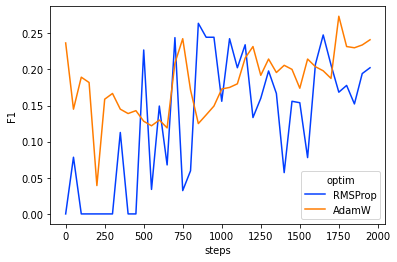

In [ ]:
sns.lineplot(data=all_optim_data, y='F1', x='steps', hue='optim', palette='bright')

In [ ]:
# recreate sparse tensor and matrix
X_train_tokenized = []
documents = train_data['text'].values
for doc in documents:
    X_train_tokenized.append(tokenize(doc))
# X_dev tokenized
X_dev_tokenized = []
for word in X_dev:
  X_dev_tokenized.append(tokenize(word))

# X_train
X_train_t_sparse, master_list_t = build_sparse_tdm(X_train_tokenized)
X_train_t_tensor = to_sparse_tensor(X_train_t_sparse)

# X_dev
X_dev_t_sparse = rebuild_sparse_tdm(X_dev_tokenized, master_list_t)
X_dev_t_tensor = to_sparse_tensor(X_dev_t_sparse)

model = LogisticRegression(list(X_train_t_tensor[0].shape)[0])

loss_vals, all_dev_loss, all_f1 = train_py_torch_model(X_train_t_tensor, y_train_tensor, X_dev_t_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=2000, pytorch_lr=0.01, need_to_eval=True, evaluate_on_n_step=50)
data_t = pd.DataFrame(columns = ['steps', 'loss', 'F1'])
data_t['steps'] = list(range(0, 2000, 50))
data_t['loss'] = all_dev_loss
data_t['F1'] = all_f1

Input shape: (3467, 4407)
Post shape: (3467, 4407)
Row: 49283, Col: 49283, data: 49283
Post post shape: torch.Size([3467, 4407])
Input shape: (280, 4407)
Post shape: (280, 4407)
Row: 3131, Col: 3131, data: 3131
Post post shape: torch.Size([280, 4407])
Done


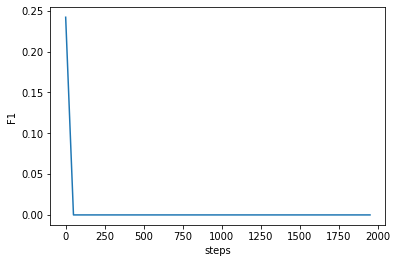

In [ ]:
sns.lineplot(data=data_t, y='F1', x='steps', palette='bright')

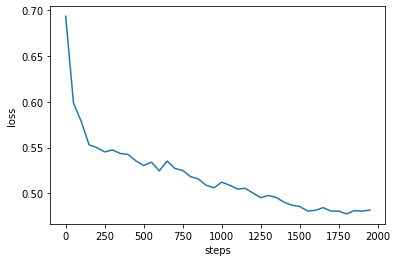

In [ ]:
sns.lineplot(data=data_t, y='loss', x='steps', palette='bright')

In [ ]:
model = LogisticRegression(list(sparse_tdm_tensor[0].shape)[0])

loss_vals_lr_high, all_dev_loss_lr_high, all_f1_lr_high = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=2000, pytorch_lr=0.7, need_to_eval=True, evaluate_on_n_step=50)
data_t_lr_high = pd.DataFrame(columns = ['steps', 'loss', 'F1'])
data_t_lr_high['steps'] = list(range(0, 2000, 50))
data_t_lr_high['loss'] = all_dev_loss_lr_high
data_t_lr_high['F1'] = all_f1_lr_high
data_t_lr_high['LR'] = 0.7

loss_vals_lr_low, all_dev_loss_lr_low, all_f1_lr_low = train_py_torch_model(sparse_tdm_tensor, y_train_tensor, X_dev_sparse_tensor, y_dev_tensor, pytorch_epochs=1, pytorch_steps=2000, pytorch_lr=0.0005, need_to_eval=True, evaluate_on_n_step=50)
data_t_lr_low = pd.DataFrame(columns = ['steps', 'loss', 'F1'])
data_t_lr_low['steps'] = list(range(0, 2000, 50))
data_t_lr_low['loss'] = all_dev_loss_lr_low
data_t_lr_low['F1'] = all_f1_lr_low
data_t_lr_low['LR'] = 0.0005
all_tr_data = pd.concat([data_t_lr_high, data_t_lr_low], ignore_index=True)

Done
Done


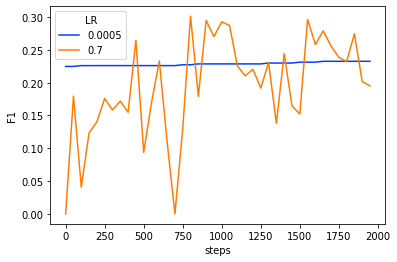

In [ ]:
sns.lineplot(data=all_tr_data, y='F1', x='steps', hue='LR', palette='bright')

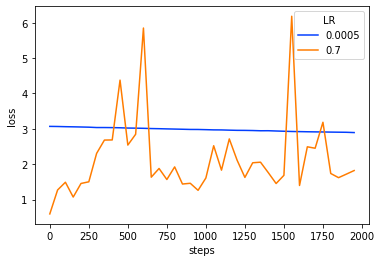

In [ ]:
sns.lineplot(data=all_tr_data, y='loss', x='steps', hue='LR', palette='bright')